In [1]:
library(ggplot2)
library(readxl)
library(stringr)
library(dplyr)
library(reshape)
library(lubridate)
library(zoo)
library(MASS)
library(LaplacesDemon)
library(gsynth)
library(doParallel)
library(foreach)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename



Attaching package: ‘lubridate’


The following object is masked from ‘package:reshape’:

    stamp


The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘LaplacesDemon’


The following objects are masked from ‘package:lubridate’:

    dst, interval


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading 

In [2]:
max_available_clusters <- detectCores()-1
  
desired_clusters <- 4
  
cl <- makeCluster(min(c(max_available_clusters, desired_clusters)))

registerDoParallel(cl)

In [3]:
source('../causal_inference_methods_code.R')

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:reshape’:

    expand


Loaded glmnet 3.0-2




In [4]:
max_available_clusters <- detectCores()-1
  
desired_clusters <- 4
  
cl <- makeCluster(min(c(max_available_clusters, desired_clusters)))

registerDoParallel(cl)

In [5]:
variableExpander <- function(keysAndVariable, unitKey, timeKey){ ### Expands into unit/time format
  
  orderedData <- keysAndVariable %>% arrange(get(unitKey), get(timeKey))
  
  outcomeName <- names(keysAndVariable)[!(names(keysAndVariable) %in% c(unitKey, timeKey))]
  
  outcomeMatrixForm <- matrix(NA, nrow=length(unique(keysAndVariable[, unitKey])), 
                              ncol=length(unique(keysAndVariable[, timeKey])), byrow=T)
  
  rownames(outcomeMatrixForm) <- unique(keysAndVariable[, unitKey])
  
  colnames(outcomeMatrixForm) <- str_replace_all(unique(keysAndVariable[, timeKey])[order(unique(keysAndVariable[, timeKey]))], pattern="-", replace="")
  
  for (index in 1:length(keysAndVariable[, unitKey])){
    
    outcomeMatrixForm[keysAndVariable[, unitKey][index], str_replace_all(keysAndVariable[, timeKey][index], pattern="-", replace="")] <- keysAndVariable[, outcomeName][index]
    
  }
  
  return(outcomeMatrixForm)
  
}

In [6]:
seriesWithUnemploymentDecay <- function(aSeries, finalProp=.96, decayRate=.1, treatmentIndexer){ ### Creates treatment effect for implementation of drunk driving law
    
    if (length(aSeries) != length(treatmentIndexer)){
        
        stop("Series and Treatment Indexer Must be the Same Length.")
    }
    
    if (all(treatmentIndexer==0)){
        
        return(aSeries)
        
    }else{
    
        dataWhereTransformNeeded <- aSeries[treatmentIndexer==1]
    
        transformedPart <- finalProp*dataWhereTransformNeeded+(1-finalProp)*dataWhereTransformNeeded*exp(-1*decayRate*(1:length(dataWhereTransformNeeded)))
        
        aSeries[treatmentIndexer==1] <- transformedPart
        
        return(aSeries)
        
    }
    
}

# Unemployment Data Provided by St. Louis Fed

In [7]:
firstSet <- read_excel('GeoFRED_Unemployment_Rate_by_County_Percent.xls', sheet=1)
colnames(firstSet) <- tolower(str_replace_all(colnames(firstSet), pattern=' ', replace='_'))


secondSet <- read_excel('GeoFRED_Unemployment_Rate_by_County_Percent.xls', sheet=2)
colnames(secondSet) <- tolower(str_replace_all(colnames(secondSet), pattern=' ', replace='_'))

fullSet <- (firstSet %>% inner_join(secondSet))

fullSet <- fullSet[!apply(fullSet, MARGIN=1, FUN=function(x) any(is.na(x))), 1:(min(which(str_detect(colnames(fullSet), '2020')))-1)]

justTimeSeriesData <- as.numeric(t(as.matrix(fullSet[4:dim(fullSet)[2]])))

Joining, by = c("series_id", "region_name", "region_code")



In [8]:
sum(apply(fullSet, MARGIN=1, FUN=function(x) any(is.na(x))))

[1] 0

In [9]:
allIds <- fullSet[, 1:3] %>% slice(rep(1:n(), each = length(4:dim(fullSet)[2])))

In [10]:
meltedUnemploymentData <- cbind.data.frame(allIds, justTimeSeriesData)
names(meltedUnemploymentData)[4] <- 'unemployment_rate'
meltedUnemploymentData <- meltedUnemploymentData %>% 
mutate(region_designation=str_extract(region_name, pattern='^.*(?=\\,)'), 
       state=str_extract(region_name, pattern='[A-Z]{2}$'))

In [11]:
timePoints <- seq(1990, 2019+(11/12), 1/12)

In [12]:
meltedUnemploymentData <- meltedUnemploymentData %>% group_by(region_code) %>% 
mutate(time=timePoints, 
      seasonal_adjust_unemp = rollmean(unemployment_rate, 12, na.pad = TRUE)) %>% ungroup() %>% filter(!(state %in% c('AK', 'HI')))

In [13]:
countiesToPlot <- 'Ventura|San Bernardino|Riverside|Los Angeles|Imperial|San Diego|Santa Barbara|Orange|San Luis Obispo|Kern'

soCalData <- meltedUnemploymentData %>% filter(str_detect(region_designation, countiesToPlot) &
                                              state=='CA')

In [14]:
names(soCalData)

[1] "series_id"             "region_name"           "region_code"          
[4] "unemployment_rate"     "region_designation"    "state"                
[7] "time"                  "seasonal_adjust_unemp"

In [28]:
socalUnempPlot <- ggplot(soCalData, aes(x=time, y=seasonal_adjust_unemp, col=region_designation)) + geom_line(lwd=1.5) + 
theme_bw(base_size=20) + ylab('Unemployment Rate (Seasonally Adjusted)') + xlab('Time') +
guides(col=guide_legend(title="County")) + ggtitle("Unemployment in Southern California")

Warning message:
“Removed 110 row(s) containing missing values (geom_path).”


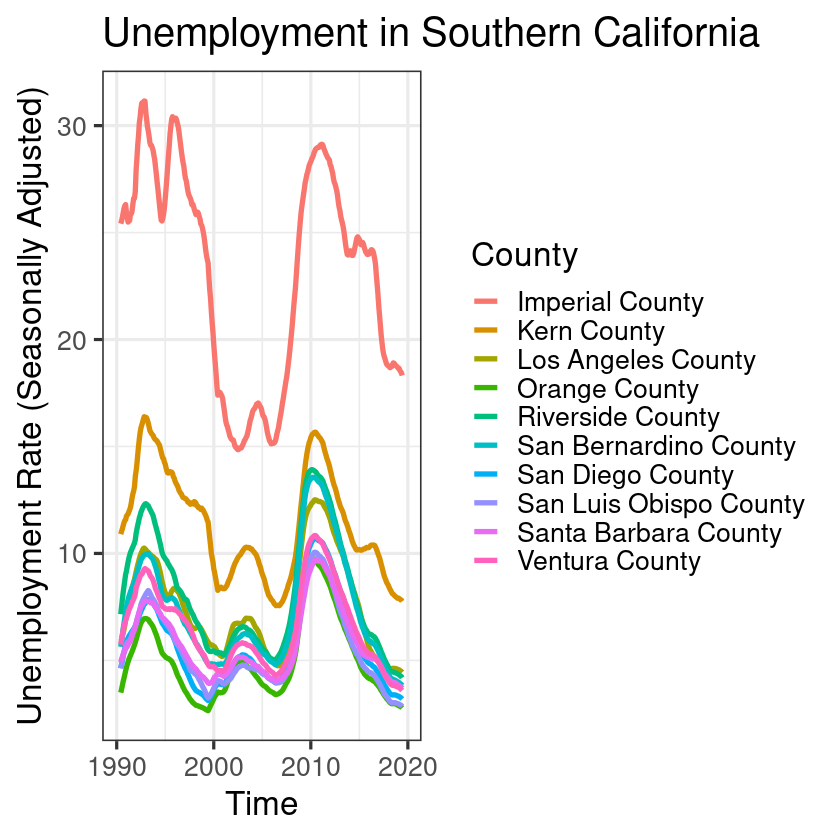

In [29]:
socalUnempPlot

In [16]:
validSmoothedDataOnly <- meltedUnemploymentData %>% filter(!is.na(seasonal_adjust_unemp))

In [17]:
fullOutcomeData <- variableExpander(data.frame(validSmoothedDataOnly[c('region_code', 'time', 'seasonal_adjust_unemp')]), unitKey='region_code', timeKey='time')

In [18]:
sum(is.na(fullOutcomeData))

[1] 0

In [19]:
unique(table(meltedUnemploymentData$region_code)) ### Verifies all series observed at all time points

[1] 360

In [20]:
aCounty <- validSmoothedDataOnly %>% filter(region_designation=='Ventura County')

In [21]:
recessionDates <- rbind(c("1990-07-01", "1991-03-01"), 
                        c("2001-03-01", "2001-11-01"), 
                        c("2007-12-01", "2009-06-01"))



In [22]:
recessionDates

1990-07-01,1991-03-01
2001-03-01,2001-11-01
2007-12-01,2009-06-01


# Generating an Artificial Treatment Design

In [23]:
propTreat <- .2
numberOfIterations <- 100
timeConsidered=24

In [24]:
valueMatrix <- array(NA, dim=c(5, numberOfIterations),
                     dimnames=c(list(c('MC-NNM', 'Synthetic Control', 
                                 'Generalized Synthetic Control', 'Synthetic Difference in Differences',
                                 'LAPIS')), list(paste('Iteration', 1:numberOfIterations, sep='_'))))


for (simNumber in 1:numberOfIterations){
    
    numberTreat <- floor(dim(fullOutcomeData)[1]*propTreat)

    numberUntreat <- dim(fullOutcomeData)[1]-numberTreat

    durations <- c(rep(0, numberUntreat) , rbinom(numberTreat, 100, .3))

    #durations <- 40*rbern(dim(fullOutcomeData)[1], propTreat)

    durations <- sample(durations, size=length(durations), replace=FALSE)
    
    
    D <- array(0, dim=dim(fullOutcomeData))

    dimnames(D) <- dimnames(fullOutcomeData)

    for (i in 1:length(durations)){
    
        allTimes <- 1:dim(D)[2]
    
        D[i, dim(D)[2]-durations[i]+1 <= allTimes] <- 1
    }
    
    observedData<- t(sapply(1:dim(fullOutcomeData)[1], FUN=function(x) seriesWithUnemploymentDecay(aSeries=fullOutcomeData[x,], 
                                                                                          finalProp=.6, decayRate=.05, 
                                    treatmentIndexer = D[x,])))
                                        
    dimnames(observedData) <- dimnames(fullOutcomeData)  
    
    meltedD <- melt(D) 

    names(meltedD) <- c('id', 'time', 'treated')

    meltedObservedData <- melt(observedData)

    names(meltedObservedData) <- c('id', 'time', 'adj_unemp')

    joinedDataForGsynth <- meltedD %>% inner_join(meltedObservedData)

    withMu <- LAPIS(Y=observedData, W=D)

    mcnnm_info <- matrix_completion_causal(Y=observedData, W=D)

    mcnnm_est <- treat.estimator(observedData, mcnnm_info$L_hat, D)

    synthContEst <- synth_cont(Y=observedData, W=D)

    gsynthInfo <- gsynth(adj_unemp~treated, data=joinedDataForGsynth, index=c('id', 'time'), 
                         parallel = TRUE,
                        r=rankMatrix(mcnnm_info$L_hat)[1])

    gsynthContEst <- gsynthInfo$att
                            
    relevantgsynthcontEst <- gsynthContEst[which(names(gsynthContEst)==1):length(gsynthContEst)]

    SDIDEst <- SDID_general(Y=observedData, W=D,
                     iterations_for_coord_desc=100)

    trueEffect <- treat.estimator(observedData, fullOutcomeData, D)
                            
                            
    errorsThisIteration <- c(mean((mcnnm_est-trueEffect)[1:timeConsidered]^2), 
                             mean((synthContEst-trueEffect)[1:timeConsidered]^2),
                             mean((relevantgsynthcontEst-trueEffect)[1:timeConsidered]^2),
                             mean((SDIDEst-trueEffect)[1:timeConsidered]^2),
                             mean((withMu-trueEffect)[1:timeConsidered]^2))
                            
                            
    valueMatrix[ , simNumber] <- errorsThisIteration
                            
    print(simNumber)
 
    }

Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72814; IC = -0.22796; MSPE = 0.79123
 r = 3; sigma2 = 0.56480; IC = -0.43737; MSPE = 0.60816
 r = 4; sigma2 = 0.42891; IC = -0.66802; MSPE = 0.47389
 r = 5; sigma2 = 0.35956; IC = -0.79986; MSPE = 0.39289

 r* = 5

[1] 1


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74117; IC = -0.21022; MSPE = 0.72852
 r = 3; sigma2 = 0.57414; IC = -0.42097; MSPE = 0.56127
 r = 4; sigma2 = 0.43622; IC = -0.65112; MSPE = 0.44224
 r = 5; sigma2 = 0.36503; IC = -0.78474; MSPE = 0.37039

 r* = 5

[1] 2


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72710; IC = -0.22938; MSPE = 0.78795
 r = 3; sigma2 = 0.56222; IC = -0.44196; MSPE = 0.61191
 r = 4; sigma2 = 0.43042; IC = -0.66450; MSPE = 0.46825
 r = 5; sigma2 = 0.35904; IC = -0.80129; MSPE = 0.39697

 r* = 5

[1] 3


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74049; IC = -0.21114; MSPE = 0.73755
 r = 3; sigma2 = 0.56922; IC = -0.42958; MSPE = 0.59067
 r = 4; sigma2 = 0.42719; IC = -0.67204; MSPE = 0.48311
 r = 5; sigma2 = 0.35693; IC = -0.80718; MSPE = 0.40630

 r* = 5

[1] 4


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74393; IC = -0.20650; MSPE = 0.71444
 r = 3; sigma2 = 0.57769; IC = -0.41481; MSPE = 0.54677
 r = 4; sigma2 = 0.43767; IC = -0.64781; MSPE = 0.43468
 r = 5; sigma2 = 0.36668; IC = -0.78024; MSPE = 0.36070

 r* = 5

[1] 5


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.75550; IC = -0.19106; MSPE = 0.67138
 r = 3; sigma2 = 0.58305; IC = -0.40557; MSPE = 0.52863
 r = 4; sigma2 = 0.44113; IC = -0.63993; MSPE = 0.42480
 r = 5; sigma2 = 0.36751; IC = -0.77797; MSPE = 0.36419

 r* = 5

[1] 6


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73412; IC = -0.21978; MSPE = 0.75902
 r = 3; sigma2 = 0.56924; IC = -0.42954; MSPE = 0.58193
 r = 4; sigma2 = 0.43324; IC = -0.65798; MSPE = 0.45527
 r = 5; sigma2 = 0.36240; IC = -0.79198; MSPE = 0.38094

 r* = 5

[1] 7


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73955; IC = -0.21240; MSPE = 0.74318
 r = 3; sigma2 = 0.57513; IC = -0.41925; MSPE = 0.56399
 r = 4; sigma2 = 0.43317; IC = -0.65814; MSPE = 0.45942
 r = 5; sigma2 = 0.36289; IC = -0.79063; MSPE = 0.38240

 r* = 5

[1] 8


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72860; IC = -0.22732; MSPE = 0.78725
 r = 3; sigma2 = 0.56959; IC = -0.42894; MSPE = 0.58573
 r = 4; sigma2 = 0.43217; IC = -0.66044; MSPE = 0.46391
 r = 5; sigma2 = 0.36194; IC = -0.79325; MSPE = 0.38619

 r* = 5

[1] 9


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.71937; IC = -0.24007; MSPE = 0.81564
 r = 3; sigma2 = 0.56165; IC = -0.44297; MSPE = 0.60746
 r = 4; sigma2 = 0.43025; IC = -0.66491; MSPE = 0.46648
 r = 5; sigma2 = 0.35887; IC = -0.80178; MSPE = 0.39349

 r* = 5

[1] 10


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74256; IC = -0.20834; MSPE = 0.72525
 r = 3; sigma2 = 0.57499; IC = -0.41949; MSPE = 0.56032
 r = 4; sigma2 = 0.43664; IC = -0.65015; MSPE = 0.44259
 r = 5; sigma2 = 0.36554; IC = -0.78336; MSPE = 0.36891

 r* = 5

[1] 11


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72769; IC = -0.22858; MSPE = 0.78703
 r = 3; sigma2 = 0.56500; IC = -0.43702; MSPE = 0.60557
 r = 4; sigma2 = 0.42970; IC = -0.66619; MSPE = 0.46980
 r = 5; sigma2 = 0.35829; IC = -0.80338; MSPE = 0.39852

 r* = 5

[1] 12


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73866; IC = -0.21361; MSPE = 0.73742
 r = 3; sigma2 = 0.57692; IC = -0.41614; MSPE = 0.54717
 r = 4; sigma2 = 0.43869; IC = -0.64548; MSPE = 0.42865
 r = 5; sigma2 = 0.36648; IC = -0.78077; MSPE = 0.36024

 r* = 5

[1] 13


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72141; IC = -0.23724; MSPE = 0.81779
 r = 3; sigma2 = 0.56087; IC = -0.44436; MSPE = 0.62495
 r = 4; sigma2 = 0.42757; IC = -0.67115; MSPE = 0.48514
 r = 5; sigma2 = 0.35815; IC = -0.80378; MSPE = 0.40439

 r* = 5

[1] 14


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73702; IC = -0.21584; MSPE = 0.74712
 r = 3; sigma2 = 0.57512; IC = -0.41927; MSPE = 0.55764
 r = 4; sigma2 = 0.43619; IC = -0.65119; MSPE = 0.44045
 r = 5; sigma2 = 0.36511; IC = -0.78453; MSPE = 0.36815

 r* = 5

[1] 15


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74139; IC = -0.20992; MSPE = 0.72718
 r = 3; sigma2 = 0.57497; IC = -0.41953; MSPE = 0.55887
 r = 4; sigma2 = 0.43796; IC = -0.64714; MSPE = 0.43469
 r = 5; sigma2 = 0.36699; IC = -0.77938; MSPE = 0.36032

 r* = 5

[1] 16


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74429; IC = -0.20602; MSPE = 0.72149
 r = 3; sigma2 = 0.58164; IC = -0.40800; MSPE = 0.53525
 r = 4; sigma2 = 0.44064; IC = -0.64105; MSPE = 0.42309
 r = 5; sigma2 = 0.36963; IC = -0.77222; MSPE = 0.34943

 r* = 5

[1] 17


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73618; IC = -0.21698; MSPE = 0.75329
 r = 3; sigma2 = 0.57029; IC = -0.42769; MSPE = 0.58338
 r = 4; sigma2 = 0.43060; IC = -0.66409; MSPE = 0.46689
 r = 5; sigma2 = 0.35953; IC = -0.79994; MSPE = 0.39382

 r* = 5

[1] 18


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.75142; IC = -0.19649; MSPE = 0.68228
 r = 3; sigma2 = 0.57896; IC = -0.41260; MSPE = 0.54075
 r = 4; sigma2 = 0.44165; IC = -0.63876; MSPE = 0.41875
 r = 5; sigma2 = 0.36879; IC = -0.77451; MSPE = 0.35393

 r* = 5

[1] 19


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72952; IC = -0.22606; MSPE = 0.77864
 r = 3; sigma2 = 0.57081; IC = -0.42678; MSPE = 0.57698
 r = 4; sigma2 = 0.43404; IC = -0.65613; MSPE = 0.44857
 r = 5; sigma2 = 0.36372; IC = -0.78835; MSPE = 0.37158

 r* = 5

[1] 20


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73759; IC = -0.21505; MSPE = 0.74242
 r = 3; sigma2 = 0.56645; IC = -0.43445; MSPE = 0.59475
 r = 4; sigma2 = 0.43179; IC = -0.66134; MSPE = 0.45993
 r = 5; sigma2 = 0.36183; IC = -0.79354; MSPE = 0.38235

 r* = 5

[1] 21


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73748; IC = -0.21521; MSPE = 0.75073
 r = 3; sigma2 = 0.57856; IC = -0.41330; MSPE = 0.54827
 r = 4; sigma2 = 0.43809; IC = -0.64685; MSPE = 0.43705
 r = 5; sigma2 = 0.36656; IC = -0.78056; MSPE = 0.36600

 r* = 5

[1] 22


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72306; IC = -0.23495; MSPE = 0.80278
 r = 3; sigma2 = 0.56378; IC = -0.43917; MSPE = 0.60859
 r = 4; sigma2 = 0.43430; IC = -0.65554; MSPE = 0.45082
 r = 5; sigma2 = 0.36222; IC = -0.79247; MSPE = 0.38250

 r* = 5

[1] 23


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74477; IC = -0.20537; MSPE = 0.71851
 r = 3; sigma2 = 0.57846; IC = -0.41347; MSPE = 0.54874
 r = 4; sigma2 = 0.43847; IC = -0.64598; MSPE = 0.43514
 r = 5; sigma2 = 0.36661; IC = -0.78043; MSPE = 0.36434

 r* = 5

[1] 24


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73856; IC = -0.21374; MSPE = 0.73965
 r = 3; sigma2 = 0.57168; IC = -0.42526; MSPE = 0.57217
 r = 4; sigma2 = 0.43231; IC = -0.66011; MSPE = 0.46028
 r = 5; sigma2 = 0.36218; IC = -0.79258; MSPE = 0.38257

 r* = 5

[1] 25


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74338; IC = -0.20725; MSPE = 0.72546
 r = 3; sigma2 = 0.57480; IC = -0.41982; MSPE = 0.56560
 r = 4; sigma2 = 0.43288; IC = -0.65880; MSPE = 0.45865
 r = 5; sigma2 = 0.36196; IC = -0.79320; MSPE = 0.38426

 r* = 5

[1] 26


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74592; IC = -0.20383; MSPE = 0.72025
 r = 3; sigma2 = 0.58091; IC = -0.40926; MSPE = 0.54459
 r = 4; sigma2 = 0.43819; IC = -0.64661; MSPE = 0.43580
 r = 5; sigma2 = 0.36733; IC = -0.77846; MSPE = 0.36128

 r* = 5

[1] 27


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73096; IC = -0.22410; MSPE = 0.77663
 r = 3; sigma2 = 0.56793; IC = -0.43185; MSPE = 0.59194
 r = 4; sigma2 = 0.43157; IC = -0.66185; MSPE = 0.46075
 r = 5; sigma2 = 0.35923; IC = -0.80075; MSPE = 0.39390

 r* = 5

[1] 28


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74611; IC = -0.20357; MSPE = 0.71136
 r = 3; sigma2 = 0.58036; IC = -0.41019; MSPE = 0.53858
 r = 4; sigma2 = 0.43970; IC = -0.64318; MSPE = 0.42559
 r = 5; sigma2 = 0.36728; IC = -0.77859; MSPE = 0.35874

 r* = 5

[1] 29


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72074; IC = -0.23817; MSPE = 0.81834
 r = 3; sigma2 = 0.56196; IC = -0.44241; MSPE = 0.61424
 r = 4; sigma2 = 0.42351; IC = -0.68069; MSPE = 0.49779
 r = 5; sigma2 = 0.35448; IC = -0.81407; MSPE = 0.41656

 r* = 5

[1] 30


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73056; IC = -0.22464; MSPE = 0.77307
 r = 3; sigma2 = 0.56971; IC = -0.42872; MSPE = 0.57917
 r = 4; sigma2 = 0.43224; IC = -0.66030; MSPE = 0.45841
 r = 5; sigma2 = 0.36163; IC = -0.79409; MSPE = 0.38242

 r* = 5

[1] 31


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.71800; IC = -0.24197; MSPE = 0.82216
 r = 3; sigma2 = 0.55508; IC = -0.45474; MSPE = 0.63811
 r = 4; sigma2 = 0.42224; IC = -0.68369; MSPE = 0.50041
 r = 5; sigma2 = 0.35258; IC = -0.81945; MSPE = 0.42080

 r* = 5

[1] 32


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73178; IC = -0.22297; MSPE = 0.76557
 r = 3; sigma2 = 0.56890; IC = -0.43013; MSPE = 0.58302
 r = 4; sigma2 = 0.43098; IC = -0.66322; MSPE = 0.46342
 r = 5; sigma2 = 0.35799; IC = -0.80422; MSPE = 0.40177

 r* = 5

[1] 33


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74079; IC = -0.21073; MSPE = 0.72874
 r = 3; sigma2 = 0.57700; IC = -0.41599; MSPE = 0.54720
 r = 4; sigma2 = 0.44017; IC = -0.64211; MSPE = 0.42347
 r = 5; sigma2 = 0.36697; IC = -0.77943; MSPE = 0.35967

 r* = 5

[1] 34


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73167; IC = -0.22312; MSPE = 0.77156
 r = 3; sigma2 = 0.57185; IC = -0.42497; MSPE = 0.57340
 r = 4; sigma2 = 0.43233; IC = -0.66009; MSPE = 0.45714
 r = 5; sigma2 = 0.36290; IC = -0.79061; MSPE = 0.37725

 r* = 5

[1] 35


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73980; IC = -0.21207; MSPE = 0.73590
 r = 3; sigma2 = 0.57622; IC = -0.41735; MSPE = 0.55426
 r = 4; sigma2 = 0.43757; IC = -0.64804; MSPE = 0.43922
 r = 5; sigma2 = 0.36723; IC = -0.77874; MSPE = 0.36355

 r* = 5

[1] 36


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72597; IC = -0.23094; MSPE = 0.80023
 r = 3; sigma2 = 0.56584; IC = -0.43553; MSPE = 0.60312
 r = 4; sigma2 = 0.42823; IC = -0.66962; MSPE = 0.47807
 r = 5; sigma2 = 0.35928; IC = -0.80062; MSPE = 0.39530

 r* = 5

[1] 37


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73745; IC = -0.21525; MSPE = 0.75328
 r = 3; sigma2 = 0.57179; IC = -0.42508; MSPE = 0.58134
 r = 4; sigma2 = 0.43146; IC = -0.66209; MSPE = 0.46399
 r = 5; sigma2 = 0.36033; IC = -0.79770; MSPE = 0.39129

 r* = 5

[1] 38


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73336; IC = -0.22081; MSPE = 0.76717
 r = 3; sigma2 = 0.57528; IC = -0.41899; MSPE = 0.56144
 r = 4; sigma2 = 0.43603; IC = -0.65155; MSPE = 0.44332
 r = 5; sigma2 = 0.36460; IC = -0.78592; MSPE = 0.37102

 r* = 5

[1] 39


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73553; IC = -0.21785; MSPE = 0.75925
 r = 3; sigma2 = 0.57384; IC = -0.42149; MSPE = 0.56842
 r = 4; sigma2 = 0.43364; IC = -0.65705; MSPE = 0.45673
 r = 5; sigma2 = 0.36311; IC = -0.79003; MSPE = 0.37978

 r* = 5

[1] 40


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72688; IC = -0.22969; MSPE = 0.79136
 r = 3; sigma2 = 0.56816; IC = -0.43144; MSPE = 0.58965
 r = 4; sigma2 = 0.43120; IC = -0.66270; MSPE = 0.46224
 r = 5; sigma2 = 0.36124; IC = -0.79517; MSPE = 0.38551

 r* = 5

[1] 41


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73442; IC = -0.21937; MSPE = 0.75891
 r = 3; sigma2 = 0.57006; IC = -0.42809; MSPE = 0.58104
 r = 4; sigma2 = 0.43341; IC = -0.65757; MSPE = 0.45790
 r = 5; sigma2 = 0.36210; IC = -0.79282; MSPE = 0.38585

 r* = 5

[1] 42


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73798; IC = -0.21453; MSPE = 0.74199
 r = 3; sigma2 = 0.57504; IC = -0.41940; MSPE = 0.55823
 r = 4; sigma2 = 0.43684; IC = -0.64971; MSPE = 0.43905
 r = 5; sigma2 = 0.36473; IC = -0.78558; MSPE = 0.37013

 r* = 5

[1] 43


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73089; IC = -0.22418; MSPE = 0.77496
 r = 3; sigma2 = 0.56895; IC = -0.43005; MSPE = 0.58560
 r = 4; sigma2 = 0.43123; IC = -0.66263; MSPE = 0.46387
 r = 5; sigma2 = 0.36151; IC = -0.79443; MSPE = 0.38489

 r* = 5

[1] 44


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73519; IC = -0.21832; MSPE = 0.75522
 r = 3; sigma2 = 0.56956; IC = -0.42898; MSPE = 0.58117
 r = 4; sigma2 = 0.43578; IC = -0.65213; MSPE = 0.44404
 r = 5; sigma2 = 0.36431; IC = -0.78673; MSPE = 0.37264

 r* = 5

[1] 45


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72841; IC = -0.22758; MSPE = 0.78888
 r = 3; sigma2 = 0.56540; IC = -0.43631; MSPE = 0.60411
 r = 4; sigma2 = 0.42860; IC = -0.66875; MSPE = 0.47909
 r = 5; sigma2 = 0.35810; IC = -0.80393; MSPE = 0.40248

 r* = 5

[1] 46


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72815; IC = -0.22795; MSPE = 0.78732
 r = 3; sigma2 = 0.56164; IC = -0.44298; MSPE = 0.61800
 r = 4; sigma2 = 0.42753; IC = -0.67125; MSPE = 0.48184
 r = 5; sigma2 = 0.35740; IC = -0.80586; MSPE = 0.40532

 r* = 5

[1] 47


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.75206; IC = -0.19563; MSPE = 0.68361
 r = 3; sigma2 = 0.58033; IC = -0.41025; MSPE = 0.53779
 r = 4; sigma2 = 0.44070; IC = -0.64091; MSPE = 0.42407
 r = 5; sigma2 = 0.36915; IC = -0.77352; MSPE = 0.35266

 r* = 5

[1] 48


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74653; IC = -0.20302; MSPE = 0.71285
 r = 3; sigma2 = 0.57700; IC = -0.41600; MSPE = 0.55818
 r = 4; sigma2 = 0.43561; IC = -0.65252; MSPE = 0.44940
 r = 5; sigma2 = 0.36563; IC = -0.78310; MSPE = 0.37373

 r* = 5

[1] 49


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73255; IC = -0.22192; MSPE = 0.76048
 r = 3; sigma2 = 0.56670; IC = -0.43401; MSPE = 0.58826
 r = 4; sigma2 = 0.43069; IC = -0.66388; MSPE = 0.46630
 r = 5; sigma2 = 0.36021; IC = -0.79803; MSPE = 0.38988

 r* = 5

[1] 50


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73210; IC = -0.22253; MSPE = 0.77100
 r = 3; sigma2 = 0.56690; IC = -0.43366; MSPE = 0.59751
 r = 4; sigma2 = 0.43181; IC = -0.66128; MSPE = 0.46035
 r = 5; sigma2 = 0.35974; IC = -0.79933; MSPE = 0.39226

 r* = 5

[1] 51


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74280; IC = -0.20802; MSPE = 0.72489
 r = 3; sigma2 = 0.57614; IC = -0.41749; MSPE = 0.55620
 r = 4; sigma2 = 0.43659; IC = -0.65029; MSPE = 0.44266
 r = 5; sigma2 = 0.36467; IC = -0.78572; MSPE = 0.37289

 r* = 5

[1] 52


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73409; IC = -0.21982; MSPE = 0.75995
 r = 3; sigma2 = 0.57050; IC = -0.42733; MSPE = 0.57912
 r = 4; sigma2 = 0.43361; IC = -0.65712; MSPE = 0.45502
 r = 5; sigma2 = 0.36155; IC = -0.79431; MSPE = 0.38585

 r* = 5

[1] 53


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73935; IC = -0.21267; MSPE = 0.73838
 r = 3; sigma2 = 0.57365; IC = -0.42183; MSPE = 0.56476
 r = 4; sigma2 = 0.43756; IC = -0.64805; MSPE = 0.43874
 r = 5; sigma2 = 0.36830; IC = -0.77583; MSPE = 0.35719

 r* = 5

[1] 54


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73386; IC = -0.22014; MSPE = 0.75734
 r = 3; sigma2 = 0.56662; IC = -0.43415; MSPE = 0.59108
 r = 4; sigma2 = 0.42980; IC = -0.66594; MSPE = 0.47015
 r = 5; sigma2 = 0.35963; IC = -0.79964; MSPE = 0.39289

 r* = 5

[1] 55


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73838; IC = -0.21399; MSPE = 0.74286
 r = 3; sigma2 = 0.57443; IC = -0.42046; MSPE = 0.56268
 r = 4; sigma2 = 0.43769; IC = -0.64776; MSPE = 0.43619
 r = 5; sigma2 = 0.36618; IC = -0.78159; MSPE = 0.36431

 r* = 5

[1] 56


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73346; IC = -0.22068; MSPE = 0.76267
 r = 3; sigma2 = 0.56715; IC = -0.43322; MSPE = 0.59342
 r = 4; sigma2 = 0.43139; IC = -0.66226; MSPE = 0.46508
 r = 5; sigma2 = 0.35993; IC = -0.79882; MSPE = 0.39339

 r* = 5

[1] 57


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73832; IC = -0.21407; MSPE = 0.74677
 r = 3; sigma2 = 0.57236; IC = -0.42408; MSPE = 0.57683
 r = 4; sigma2 = 0.43099; IC = -0.66317; MSPE = 0.46522
 r = 5; sigma2 = 0.36068; IC = -0.79673; MSPE = 0.38902

 r* = 5

[1] 58


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73036; IC = -0.22491; MSPE = 0.77760
 r = 3; sigma2 = 0.56692; IC = -0.43362; MSPE = 0.59539
 r = 4; sigma2 = 0.42987; IC = -0.66578; MSPE = 0.47297
 r = 5; sigma2 = 0.35917; IC = -0.80094; MSPE = 0.39718

 r* = 5

[1] 59


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72365; IC = -0.23414; MSPE = 0.80236
 r = 3; sigma2 = 0.56565; IC = -0.43587; MSPE = 0.59796
 r = 4; sigma2 = 0.43047; IC = -0.66440; MSPE = 0.46763
 r = 5; sigma2 = 0.35986; IC = -0.79901; MSPE = 0.39277

 r* = 5

[1] 60


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73591; IC = -0.21735; MSPE = 0.75380
 r = 3; sigma2 = 0.57123; IC = -0.42606; MSPE = 0.57696
 r = 4; sigma2 = 0.43388; IC = -0.65651; MSPE = 0.45547
 r = 5; sigma2 = 0.36426; IC = -0.78685; MSPE = 0.37563

 r* = 5

[1] 61


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.71746; IC = -0.24273; MSPE = 0.83420
 r = 3; sigma2 = 0.55654; IC = -0.45210; MSPE = 0.64032
 r = 4; sigma2 = 0.42274; IC = -0.68252; MSPE = 0.50338
 r = 5; sigma2 = 0.35688; IC = -0.80733; MSPE = 0.40667

 r* = 5

[1] 62


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72961; IC = -0.22594; MSPE = 0.78077
 r = 3; sigma2 = 0.56390; IC = -0.43897; MSPE = 0.60815
 r = 4; sigma2 = 0.42895; IC = -0.66792; MSPE = 0.47273
 r = 5; sigma2 = 0.35810; IC = -0.80391; MSPE = 0.39794

 r* = 5

[1] 63


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73670; IC = -0.21627; MSPE = 0.74599
 r = 3; sigma2 = 0.56578; IC = -0.43564; MSPE = 0.59600
 r = 4; sigma2 = 0.43036; IC = -0.66464; MSPE = 0.46782
 r = 5; sigma2 = 0.35888; IC = -0.80174; MSPE = 0.39570

 r* = 5

[1] 64


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.71177; IC = -0.25069; MSPE = 0.86214
 r = 3; sigma2 = 0.55521; IC = -0.45450; MSPE = 0.65362
 r = 4; sigma2 = 0.41664; IC = -0.69705; MSPE = 0.53142
 r = 5; sigma2 = 0.34760; IC = -0.83367; MSPE = 0.45229

 r* = 5

[1] 65


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72978; IC = -0.22570; MSPE = 0.77574
 r = 3; sigma2 = 0.56373; IC = -0.43928; MSPE = 0.60509
 r = 4; sigma2 = 0.42663; IC = -0.67335; MSPE = 0.48266
 r = 5; sigma2 = 0.35792; IC = -0.80441; MSPE = 0.39880

 r* = 5

[1] 66


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73040; IC = -0.22486; MSPE = 0.77251
 r = 3; sigma2 = 0.56322; IC = -0.44018; MSPE = 0.60649
 r = 4; sigma2 = 0.43043; IC = -0.66448; MSPE = 0.46780
 r = 5; sigma2 = 0.36117; IC = -0.79539; MSPE = 0.38775

 r* = 5

[1] 67


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73349; IC = -0.22064; MSPE = 0.75939
 r = 3; sigma2 = 0.56727; IC = -0.43301; MSPE = 0.58883
 r = 4; sigma2 = 0.43223; IC = -0.66031; MSPE = 0.45795
 r = 5; sigma2 = 0.36102; IC = -0.79578; MSPE = 0.38687

 r* = 5

[1] 68


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72484; IC = -0.23249; MSPE = 0.80382
 r = 3; sigma2 = 0.56204; IC = -0.44227; MSPE = 0.62081
 r = 4; sigma2 = 0.42510; IC = -0.67694; MSPE = 0.49369
 r = 5; sigma2 = 0.35556; IC = -0.81104; MSPE = 0.41288

 r* = 5

[1] 69


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74334; IC = -0.20730; MSPE = 0.72701
 r = 3; sigma2 = 0.57718; IC = -0.41569; MSPE = 0.55670
 r = 4; sigma2 = 0.43623; IC = -0.65110; MSPE = 0.44249
 r = 5; sigma2 = 0.36423; IC = -0.78694; MSPE = 0.37259

 r* = 5

[1] 70


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74375; IC = -0.20675; MSPE = 0.71739
 r = 3; sigma2 = 0.57481; IC = -0.41981; MSPE = 0.55964
 r = 4; sigma2 = 0.43310; IC = -0.65831; MSPE = 0.45554
 r = 5; sigma2 = 0.36191; IC = -0.79332; MSPE = 0.38673

 r* = 5

[1] 71


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73079; IC = -0.22432; MSPE = 0.78333
 r = 3; sigma2 = 0.57257; IC = -0.42371; MSPE = 0.57309
 r = 4; sigma2 = 0.43472; IC = -0.65457; MSPE = 0.45225
 r = 5; sigma2 = 0.36437; IC = -0.78655; MSPE = 0.37484

 r* = 5

[1] 72


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72300; IC = -0.23503; MSPE = 0.80510
 r = 3; sigma2 = 0.55643; IC = -0.45230; MSPE = 0.63621
 r = 4; sigma2 = 0.42165; IC = -0.68510; MSPE = 0.50457
 r = 5; sigma2 = 0.35146; IC = -0.82263; MSPE = 0.42721

 r* = 5

[1] 73


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.71759; IC = -0.24255; MSPE = 0.82223
 r = 3; sigma2 = 0.56323; IC = -0.44016; MSPE = 0.60059
 r = 4; sigma2 = 0.42747; IC = -0.67139; MSPE = 0.47601
 r = 5; sigma2 = 0.35667; IC = -0.80792; MSPE = 0.40146

 r* = 5

[1] 74


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73452; IC = -0.21923; MSPE = 0.75118
 r = 3; sigma2 = 0.56291; IC = -0.44072; MSPE = 0.60451
 r = 4; sigma2 = 0.43066; IC = -0.66395; MSPE = 0.46388
 r = 5; sigma2 = 0.35912; IC = -0.80108; MSPE = 0.39159

 r* = 5

[1] 75


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73291; IC = -0.22143; MSPE = 0.77608
 r = 3; sigma2 = 0.57312; IC = -0.42274; MSPE = 0.57798
 r = 4; sigma2 = 0.43654; IC = -0.65038; MSPE = 0.44450
 r = 5; sigma2 = 0.36712; IC = -0.77905; MSPE = 0.36273

 r* = 5

[1] 76


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72631; IC = -0.23047; MSPE = 0.79256
 r = 3; sigma2 = 0.56672; IC = -0.43397; MSPE = 0.59283
 r = 4; sigma2 = 0.42995; IC = -0.66559; MSPE = 0.47101
 r = 5; sigma2 = 0.35939; IC = -0.80032; MSPE = 0.39588

 r* = 5

[1] 77


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74744; IC = -0.20179; MSPE = 0.70857
 r = 3; sigma2 = 0.57833; IC = -0.41370; MSPE = 0.55071
 r = 4; sigma2 = 0.43421; IC = -0.65575; MSPE = 0.45279
 r = 5; sigma2 = 0.36163; IC = -0.79409; MSPE = 0.38553

 r* = 5

[1] 78


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73200; IC = -0.22267; MSPE = 0.77427
 r = 3; sigma2 = 0.57064; IC = -0.42708; MSPE = 0.58170
 r = 4; sigma2 = 0.43264; IC = -0.65936; MSPE = 0.45897
 r = 5; sigma2 = 0.36192; IC = -0.79331; MSPE = 0.38465

 r* = 5

[1] 79


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73730; IC = -0.21545; MSPE = 0.74939
 r = 3; sigma2 = 0.56978; IC = -0.42859; MSPE = 0.58434
 r = 4; sigma2 = 0.42787; IC = -0.67046; MSPE = 0.47866
 r = 5; sigma2 = 0.35777; IC = -0.80484; MSPE = 0.40009

 r* = 5

[1] 80


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74045; IC = -0.21118; MSPE = 0.73814
 r = 3; sigma2 = 0.57386; IC = -0.42145; MSPE = 0.57020
 r = 4; sigma2 = 0.43545; IC = -0.65288; MSPE = 0.44570
 r = 5; sigma2 = 0.36525; IC = -0.78414; MSPE = 0.36824

 r* = 5

[1] 81


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74704; IC = -0.20233; MSPE = 0.70635
 r = 3; sigma2 = 0.57897; IC = -0.41259; MSPE = 0.54322
 r = 4; sigma2 = 0.44161; IC = -0.63884; MSPE = 0.42063
 r = 5; sigma2 = 0.37057; IC = -0.76967; MSPE = 0.34654

 r* = 5

[1] 82


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74754; IC = -0.20166; MSPE = 0.70965
 r = 3; sigma2 = 0.57766; IC = -0.41486; MSPE = 0.55370
 r = 4; sigma2 = 0.43562; IC = -0.65251; MSPE = 0.44761
 r = 5; sigma2 = 0.36422; IC = -0.78697; MSPE = 0.37544

 r* = 5

[1] 83


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74109; IC = -0.21033; MSPE = 0.73096
 r = 3; sigma2 = 0.57295; IC = -0.42304; MSPE = 0.56897
 r = 4; sigma2 = 0.43525; IC = -0.65334; MSPE = 0.44778
 r = 5; sigma2 = 0.36479; IC = -0.78541; MSPE = 0.37155

 r* = 5

[1] 84


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.75122; IC = -0.19675; MSPE = 0.68924
 r = 3; sigma2 = 0.58458; IC = -0.40295; MSPE = 0.52163
 r = 4; sigma2 = 0.44189; IC = -0.63820; MSPE = 0.41865
 r = 5; sigma2 = 0.37106; IC = -0.76836; MSPE = 0.34596

 r* = 5

[1] 85


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73895; IC = -0.21322; MSPE = 0.74470
 r = 3; sigma2 = 0.57276; IC = -0.42337; MSPE = 0.57485
 r = 4; sigma2 = 0.43247; IC = -0.65976; MSPE = 0.45928
 r = 5; sigma2 = 0.36305; IC = -0.79019; MSPE = 0.37884

 r* = 5

[1] 86


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73050; IC = -0.22472; MSPE = 0.78195
 r = 3; sigma2 = 0.56623; IC = -0.43484; MSPE = 0.60415
 r = 4; sigma2 = 0.42949; IC = -0.66668; MSPE = 0.46998
 r = 5; sigma2 = 0.35865; IC = -0.80238; MSPE = 0.39645

 r* = 5

[1] 87


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73868; IC = -0.21358; MSPE = 0.74465
 r = 3; sigma2 = 0.57426; IC = -0.42076; MSPE = 0.56576
 r = 4; sigma2 = 0.43272; IC = -0.65919; MSPE = 0.45708
 r = 5; sigma2 = 0.36151; IC = -0.79443; MSPE = 0.38477

 r* = 5

[1] 88


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73941; IC = -0.21260; MSPE = 0.73946
 r = 3; sigma2 = 0.57366; IC = -0.42181; MSPE = 0.56690
 r = 4; sigma2 = 0.43676; IC = -0.64988; MSPE = 0.43932
 r = 5; sigma2 = 0.36560; IC = -0.78319; MSPE = 0.36667

 r* = 5

[1] 89


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73793; IC = -0.21460; MSPE = 0.74534
 r = 3; sigma2 = 0.57196; IC = -0.42477; MSPE = 0.57378
 r = 4; sigma2 = 0.43282; IC = -0.65894; MSPE = 0.45933
 r = 5; sigma2 = 0.36201; IC = -0.79305; MSPE = 0.38456

 r* = 5

[1] 90


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72736; IC = -0.22902; MSPE = 0.79226
 r = 3; sigma2 = 0.57054; IC = -0.42727; MSPE = 0.58395
 r = 4; sigma2 = 0.42814; IC = -0.66981; MSPE = 0.47759
 r = 5; sigma2 = 0.35921; IC = -0.80083; MSPE = 0.39476

 r* = 5

[1] 91


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73599; IC = -0.21723; MSPE = 0.75155
 r = 3; sigma2 = 0.56829; IC = -0.43121; MSPE = 0.58621
 r = 4; sigma2 = 0.43342; IC = -0.65755; MSPE = 0.45617
 r = 5; sigma2 = 0.36199; IC = -0.79311; MSPE = 0.38462

 r* = 5

[1] 92


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72845; IC = -0.22753; MSPE = 0.78063
 r = 3; sigma2 = 0.57298; IC = -0.42299; MSPE = 0.56301
 r = 4; sigma2 = 0.43650; IC = -0.65047; MSPE = 0.43829
 r = 5; sigma2 = 0.36501; IC = -0.78481; MSPE = 0.36714

 r* = 5

[1] 93


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.70352; IC = -0.26235; MSPE = 0.89237
 r = 3; sigma2 = 0.54941; IC = -0.46500; MSPE = 0.67405
 r = 4; sigma2 = 0.41716; IC = -0.69580; MSPE = 0.52682
 r = 5; sigma2 = 0.34849; IC = -0.83113; MSPE = 0.44252

 r* = 5

[1] 94


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72386; IC = -0.23386; MSPE = 0.80659
 r = 3; sigma2 = 0.56230; IC = -0.44180; MSPE = 0.61549
 r = 4; sigma2 = 0.42615; IC = -0.67448; MSPE = 0.48606
 r = 5; sigma2 = 0.35670; IC = -0.80782; MSPE = 0.40633

 r* = 5

[1] 95


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72655; IC = -0.23014; MSPE = 0.79886
 r = 3; sigma2 = 0.56816; IC = -0.43144; MSPE = 0.59285
 r = 4; sigma2 = 0.42936; IC = -0.66696; MSPE = 0.47086
 r = 5; sigma2 = 0.36043; IC = -0.79744; MSPE = 0.38866

 r* = 5

[1] 96


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72845; IC = -0.22754; MSPE = 0.78651
 r = 3; sigma2 = 0.56264; IC = -0.44121; MSPE = 0.61283
 r = 4; sigma2 = 0.42831; IC = -0.66942; MSPE = 0.47626
 r = 5; sigma2 = 0.35778; IC = -0.80480; MSPE = 0.40112

 r* = 5

[1] 97


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.74186; IC = -0.20929; MSPE = 0.73459
 r = 3; sigma2 = 0.57564; IC = -0.41835; MSPE = 0.56353
 r = 4; sigma2 = 0.43683; IC = -0.64972; MSPE = 0.44496
 r = 5; sigma2 = 0.36372; IC = -0.78833; MSPE = 0.38161

 r* = 5

[1] 98


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.73521; IC = -0.21830; MSPE = 0.76419
 r = 3; sigma2 = 0.57448; IC = -0.42038; MSPE = 0.56916
 r = 4; sigma2 = 0.43386; IC = -0.65655; MSPE = 0.45295
 r = 5; sigma2 = 0.36269; IC = -0.79117; MSPE = 0.37965

 r* = 5

[1] 99


Joining, by = c("id", "time")



Cross-validating ... 
 r = 2; sigma2 = 0.72684; IC = -0.22974; MSPE = 0.78802
 r = 3; sigma2 = 0.56479; IC = -0.43740; MSPE = 0.60101
 r = 4; sigma2 = 0.42989; IC = -0.66573; MSPE = 0.47063
 r = 5; sigma2 = 0.35959; IC = -0.79976; MSPE = 0.39329

 r* = 5

[1] 100


In [25]:
oneYearOfAdoption <- rownames(D)[rowSums(D) >= 12 ]
CACountiesThatAdopted <- validSmoothedDataOnly %>% filter(region_code %in% oneYearOfAdoption & state=='CA')

countyOfInterest <- sample(CACountiesThatAdopted$region_code, 1)

In [26]:
adoptionTime <- as.numeric(colnames(D)[max(which((D[countyOfInterest, ]==0)))])

In [27]:
unempVals <- as.numeric(c(observedData[countyOfInterest ,], fullOutcomeData[countyOfInterest, ]))
times <- as.numeric(rep(colnames(D), 2))
treatVals <- rep(c("Observed", "Untreated Potential Outcome"), each=dim(D)[2])

In [28]:
adoptionDataCountyExample <- cbind.data.frame(times, treatVals, unempVals)

names(adoptionDataCountyExample) <- c('Time', 'Outcome', 'Unemployment')

In [29]:
adoptionExamplePlot <- ggplot(adoptionDataCountyExample %>% filter(Time >= adoptionTime-36/12), 
                              aes(x=Time, y=Unemployment, col=Outcome, lty=Outcome)) + 
geom_line(lwd=2) + theme_bw(base_size=20) + ylab('Unemployment Rate (Seasonally Adjusted)') + xlab('Time') +
 ggtitle("A Successful Retraining Program?") + geom_vline(xintercept = adoptionTime, lwd=1.25) 


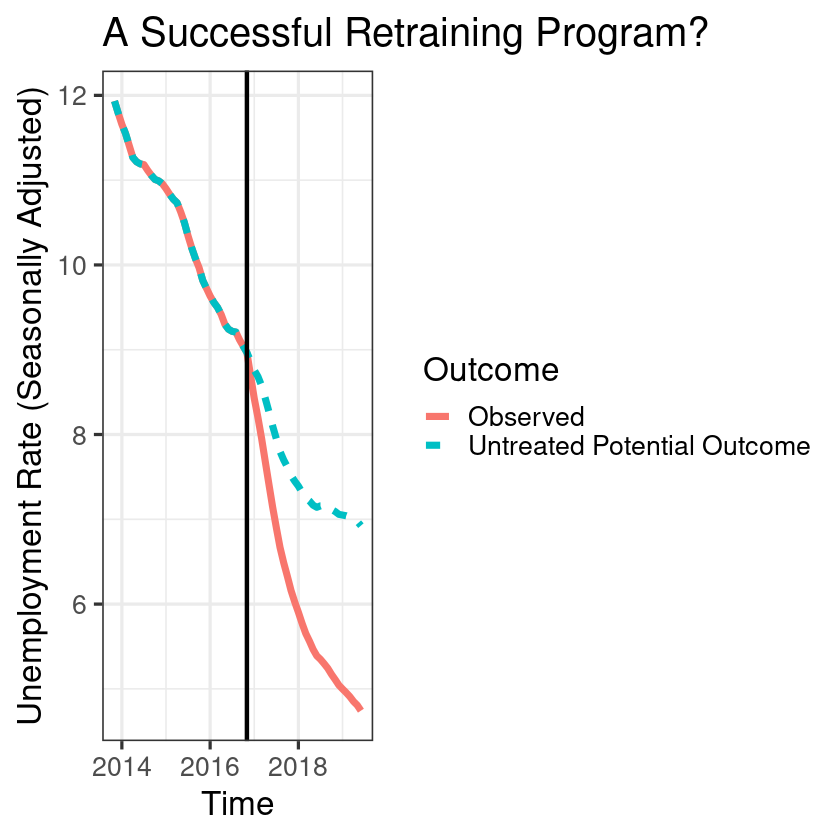

In [30]:
adoptionExamplePlot

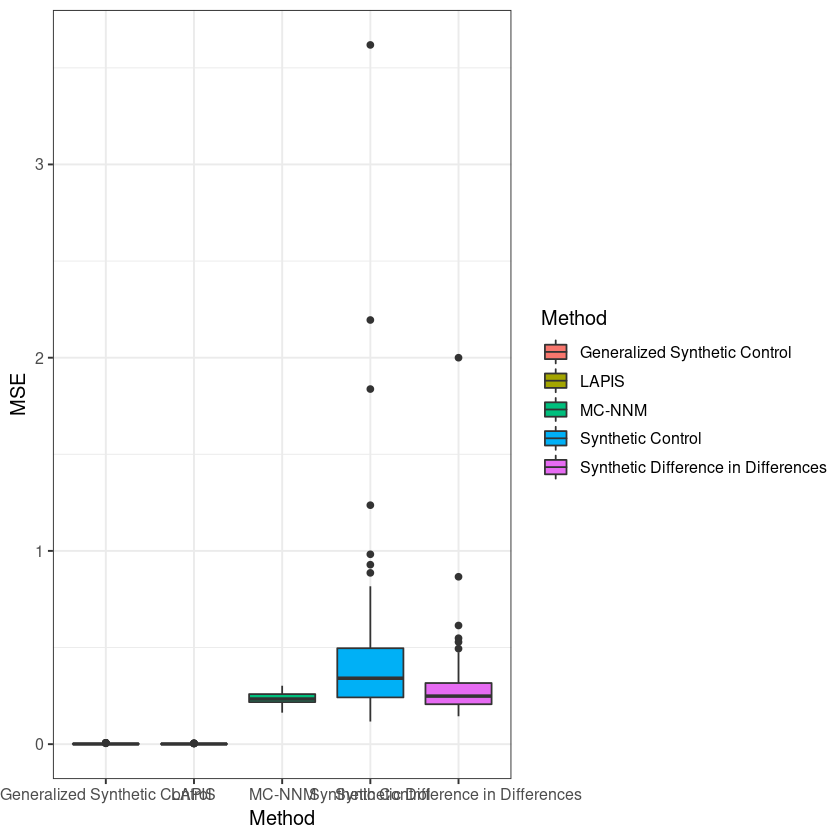

In [31]:
meltedErrors <- melt(valueMatrix)

names(meltedErrors) <- c('Method', 'Itertation', 'MSE')

ggplot(meltedErrors, aes(x=Method, y=MSE, fill=Method)) + geom_boxplot() + theme_bw(base_size=12)

In [32]:
aggregatedErrors <- meltedErrors %>% group_by(Method) %>% summarize(RMSE = round(sqrt(mean(MSE, na.rm=T)), 3),
                                               SE = round(sd(MSE, na.rm=T)/n(), 3))

In [33]:
aggregatedErrors$`RMSE (SE)` <- paste(aggregatedErrors$RMSE, ' (', aggregatedErrors$SE, ')', sep='')

aggregatedErrors$Method <- factor(aggregatedErrors$Method, levels=c("Synthetic Control", 'Generalized Synthetic Control',
                                                            'Synthetic Difference in Differences',
                                                            'MC-NNM', 'LAPIS'))


aggregatedErrors <- aggregatedErrors[order(aggregatedErrors$Method), ]

In [34]:
tableForLatex <- aggregatedErrors[, c('Method', 'RMSE (SE)')]

In [35]:
latexRMSETable <- knitr::kable(tableForLatex, format='latex')

In [36]:
estData <- c(synthContEst, relevantgsynthcontEst, SDIDEst, mcnnm_est, withMu, trueEffect)

methodValues <- rep(c("Synthetic Control", 'Generalized Synthetic Control',
                                                            'Synthetic Difference in Differences',
                                                            'MC-NNM', 'LAPIS', 'Truth'), each=length(trueEffect))

relativeTime <- rep(1:length(trueEffect), length.out=length(methodValues))

In [37]:
plotExample <- cbind.data.frame(methodValues, relativeTime ,estData)

names(plotExample) <- c('Method', 'Time', 'Change in Seasonally Adjusted Unemployment Rate')

plotExample <- plotExample %>% filter(Time <= timeConsidered)

In [38]:
effectPlot <- ggplot(plotExample, aes(x=Time, y=`Change in Seasonally Adjusted Unemployment Rate`, col=Method)) + 
geom_line(lwd=2) + theme_bw(base_size=20)

In [42]:
adoptionDurations <- rowSums(D)

In [49]:
adoptionDistribution <- table(adoptionDurations)

In [66]:
adoptDistData <- cbind.data.frame(as.numeric(names(adoptionDistribution)), as.numeric(adoptionDistribution))

names(adoptDistData) <- c('Duration', 'Count')

In [71]:
adoptDistExamp <- ggplot(adoptDistData, aes(x=Duration, y=log(Count))) + geom_bar(stat="identity",width=.1) + 
geom_point() + theme_bw(base_size=20) + theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) + xlab("Adoption Duration") + ggtitle("Adoption of a Job Retraining Program")

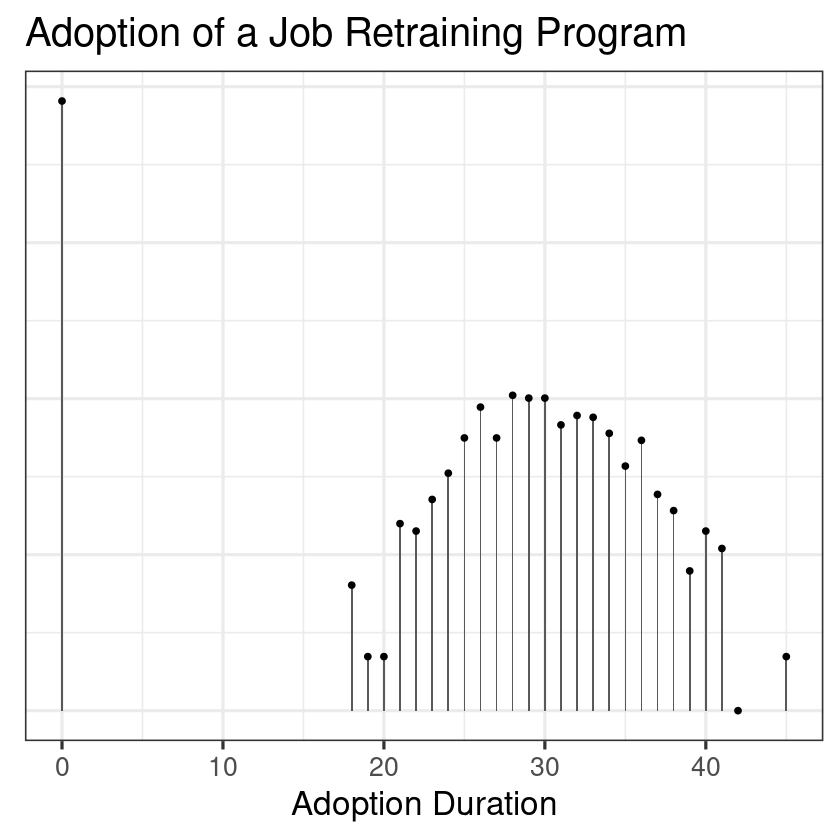

In [72]:
adoptDistExamp 

In [39]:
if (!exists('./plots_and_tables')){
    
    
    dir.create('plots_and_tables')
}

Warning message in dir.create("plots_and_tables"):
“'plots_and_tables' already exists”


In [73]:
ggsave('plots_and_tables/unemployment_change.pdf', effectPlot, width=11, height=8.5 )
ggsave('plots_and_tables/unemployment_change.pdf', socalUnempPlot, width=11, height=8.5)
ggsave('plots_and_tables/program_adoption_example.pdf', adoptionExamplePlot, width=11, height=8.5)
ggsave('plots_and_tables/adoption_curve_example.pdf', adoptDistExamp, width=11, height=8.5)

fileConn<-file('plots_and_tables/unemployment_error_table.txt')
writeLines(latexRMSETable, fileConn)
close(fileConn)

Warning message:
“Removed 110 row(s) containing missing values (geom_path).”
